# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of tranfer learnoing feature extraction and fine-tuning, now it's time to scale up to all pf the classes in Food101 (101 total classes food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Our baseline to beat is 50.76% accuracy across 101 classes.

In [2]:
# Check to if we're using a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-04-09 09:57:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-09 09:57:25 (48.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 datset but has been preprocessed using the image_data_modification notebook.

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-04-09 09:57:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.184.207, 142.251.189.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.184.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   188MB/s    in 12s     

2025-04-09 09:57:45 (125 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dos model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes ( 5 epochs on the train dataset amnd validate on 15% of the test data, to save epoch time)

In [8]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1/255.)
],name="data_augmentation")


In [10]:
# Setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs) #augment images (only happens during training phase)
x = base_model(x,training=False) # Put the base model in inference mode so weights which need to stay frozzen, stay frozzen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# get a summary of model we created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Compile the model

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                      epochs=5,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      callbacks=[checkpoint_callback]
                                      )

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.1610 - loss: 3.9713 - val_accuracy: 0.4417 - val_loss: 2.5157
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.4805 - loss: 2.3396 - val_accuracy: 0.5050 - val_loss: 2.0670
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.5514 - loss: 1.9186 - val_accuracy: 0.5180 - val_loss: 1.8858
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.5925 - loss: 1.6997 - val_accuracy: 0.5410 - val_loss: 1.7874
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.6286 - loss: 1.5399 - val_accuracy: 0.5519 - val_loss: 1.7216


In [13]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1019s 1s/step - accuracy: 0.5558 - loss: 1.6845


[1.6031354665756226, 0.5754059553146362]

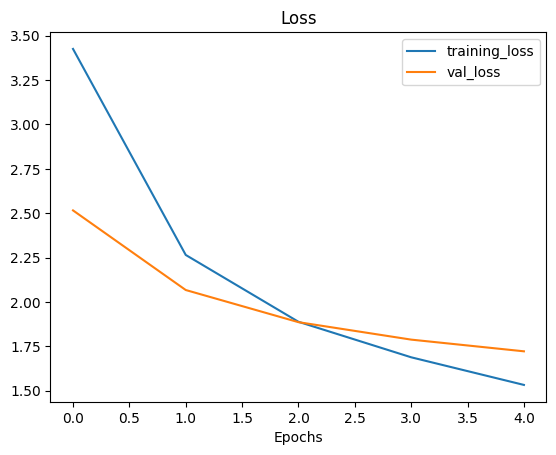

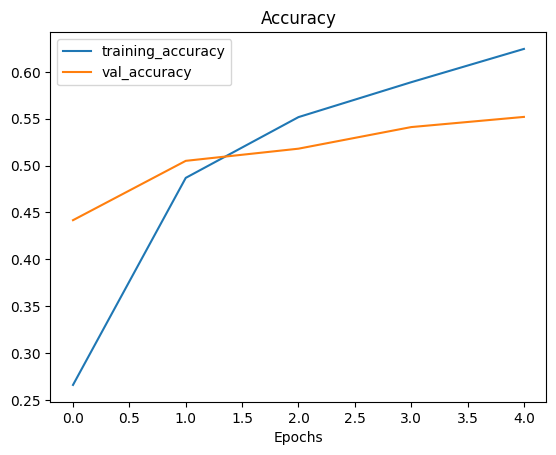

In [14]:
plot_loss_curves(history_all_classes_10_percent)

> **What do these curves suggets?** Ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performance too well ont he training data and not generalizing to unseen data).

## Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refrezze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [17]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable in EfficientNetB0?
for i, layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
initial_epochs = 5
history_fine_tuning_model = model.fit(train_data_all_10_percent,
                                      epochs = initial_epochs + 5,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6269 - loss: 1.5456 - val_accuracy: 0.5649 - val_loss: 1.6761
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.6664 - loss: 1.3377 - val_accuracy: 0.5765 - val_loss: 1.6312
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.6968 - loss: 1.2487 - val_accuracy: 0.5800 - val_loss: 1.6073
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.7014 - loss: 1.1773 - val_accuracy: 0.5863 - val_loss: 1.5826
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.7267 - loss: 1.1113 - val_accuracy: 0.5882 - val_loss: 1.5692
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.7321 - loss: 1.0698 - val_accuracy: 0.5874 - val_loss: 1.5606


In [ ]:
all_classes_fine_tune_results = model.evaluate(test_data)
all_classes_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1099s 1s/step - accuracy: 0.6007 - loss: 1.4900


[1.4094345569610596, 0.6194059252738953]

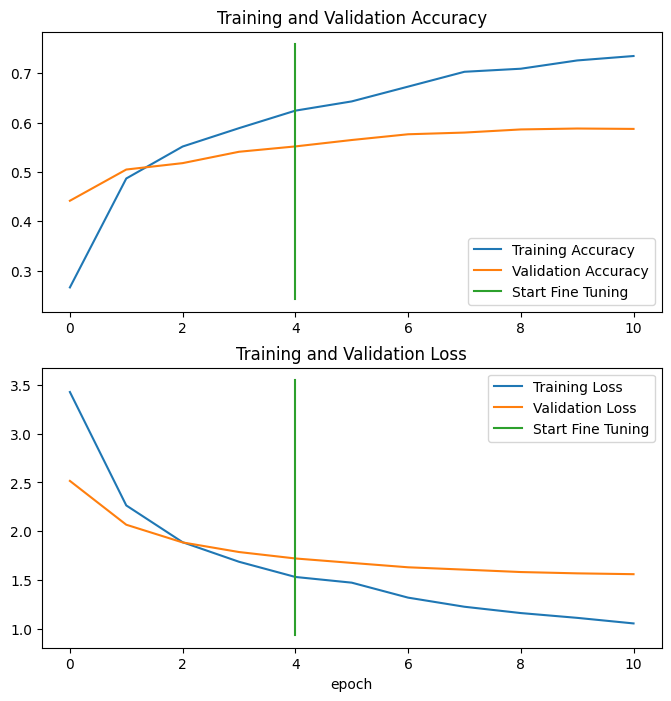

In [ ]:
# Compare histories of feature extraction model with the fine-tune model
compare_historys(history_all_classes_10_percent,history_fine_tuning_model)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model
model.save("drive/MyDrive/TensorFlow/101_food_classes_percent_saved_big_dog_model.keras")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_food_classes_percent_saved_big_dog_model.keras")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

In [ ]:
# The results of our loaded model should be very close
all_classes_fine_tune_results

## Evaluating the performance of the big dog model across all diferrent classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.layers.TFSMLayer('/content/06_101_food_class_10_percent_saved_big_dog_model', call_endpoint='serving_default')

In [ ]:
# Evaluate loaded model (the one we just dowloaded on test data
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

# Iterar sobre el dataset
for images, labels in test_data:
    predictions = model(images)  # Realiza las predicciones
    predictions = predictions['dense_8']  # Sustituye 'dense_8' por la clave de tu modelo

    # Actualiza la métrica de precisión
    accuracy_metric.update_state(labels, predictions)

# Obtener el valor final de precisión
accuracy = accuracy_metric.result().numpy()
print(f"Precisión en los datos de prueba: {accuracy}")

## Making predictions with our trained model

In [ ]:
pred_probs = []
for image, _ in test_data.unbatch():
    img_expanded = tf.expand_dims(image, axis=0)  # (1, H, W, C)

    pred_dict = model(img_expanded, training=False)  # llamada directa al modelo
    pred = pred_dict['dense_8']
    pred_probs.append(pred.numpy()[0])

In [ ]:
len(pred_probs)

In [ ]:
pred_probs[0]

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

In [ ]:
test_data.class_names[52]

In [ ]:
import numpy as np

In [ ]:
# Si cada predicción es un tensor, conviértelo a numpy
pred_probs_np = np.array([p.numpy() if tf.is_tensor(p) else p for p in pred_probs])

# Ahora sí puedes hacer argmax por filas (eje 1)
pred_classes = pred_probs_np.argmax(axis=1)

pred_classes[:10]


In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
# How many y_labels are there?
len(y_labels)

## Evaluating our model's predictions

One way to check that our model's predictions array in the same order as our test labels array is to find the accuracy score.

In [ ]:
loaded_model_results

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(loaded_model_results[1],sklearn_accuracy)

## Let's get visual: making a confusionj matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of classes
class_names = test_data.class_names
class_names[:10]

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labls vertically)

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,y_pred=pred_classes,target_names=class_names))

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get better understanding?

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

Let's plot all of our classes F1-scores...

In [ ]:
# Create a empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():

  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [ ]:
f1_scores[:10]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis() #reverse the order of our plot

## Visualizing predictions on custom  images

Now, this is the real, how does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specially it will need to:
* Read in atarget image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 (if

In [ ]:
# Create a funtion to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into
  specified shape (img_shape,img_shape,color_channels=3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (img_shape,img_shape,3)

  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img,channels=3)

  # Resize the image
  img = tf.image.resize(img,size=[img_shape,img_shape])

  #Scale? yes/no
  if scale:
    #rescale the image (get all values between 0 and 1)
    return  img/255.
  else:
    return img


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

In [ ]:
# Make preds on a series of random images
import os
import random
pred_probs = []
plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from  a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath,scale=False)

  pred_dict = model(tf.expand_dims(img,axis=0), training=False)  # llamada directa al modelo
  pred = pred_dict['dense_8']
  pred_probs.append(pred.numpy()[0])
  pred_class = class_names[pred_probs[i].argmax()]
  print(class_name,pred_class,class_name==pred_class)
  # plot the images

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
    print("red")
  plt.title(f"actual: {class_name},pred:{pred_class}",c=title_color)
  plt.axis(False)


# Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max predictions probabilities, prediction class names, ground truth class name.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't math prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong predicition.

In [ ]:
# Get all the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]


In [ ]:
# 2.Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true": y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":pred_probs_np.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels]
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [ ]:
# 3. Find out in out DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong .head(20)

In [ ]:
# 5. Visualize the test data samples which have the wrong predictions but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[i],scale=False)
  _,_,_,_,pred_probs_np,y_true_classname,y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname},pred: {y_pred_classname} \nprob: {pred_probs}")
  plt.axis(False)

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_iamges.zip")

In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_iamges")]
custom_food_images

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale=False)
  pred_dict = model(tf.expand_dims(img,axis=0), training=False)  # llamada directa al modelo
  pred = pred_dict['dense_8']
  pred_probs.append(pred.numpy()[0])
  pred_class = class_names[pred_probs[i].argmax()]
  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False)